# Explanatory Data Analysis (EDA)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk import flatten
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
nltk.download("stopwords")
from nltk import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kpy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load dataset
data = pd.read_csv("../dataset/train.csv")

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [29]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [31]:
# what is actually missing?
total = data.isna().sum().sort_values(ascending=False)
percent_1 = data.isna().sum()/data.isna().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing = pd.concat([total, percent_2], axis=1, keys=['Total', 'Percentage'])
missing.head()

,Total,Percentage
location,2533,33.3
keyword,61,0.8
target,0,0.0
text,0,0.0
id,0,0.0


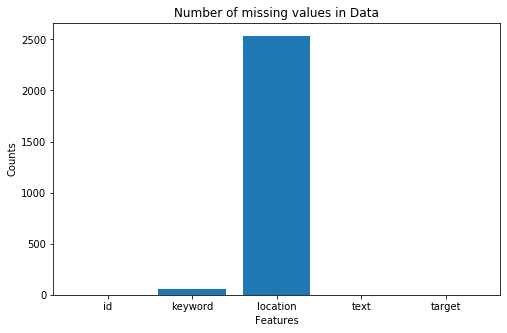

In [5]:
# Visualising missing values in train df
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(data.isna().columns, data.isna().sum())
ax.set_xlabel("Features")
ax.set_ylabel("Counts")
ax.set_title("Number of missing values in Data")
plt.show()

Total keywords in train set: 221


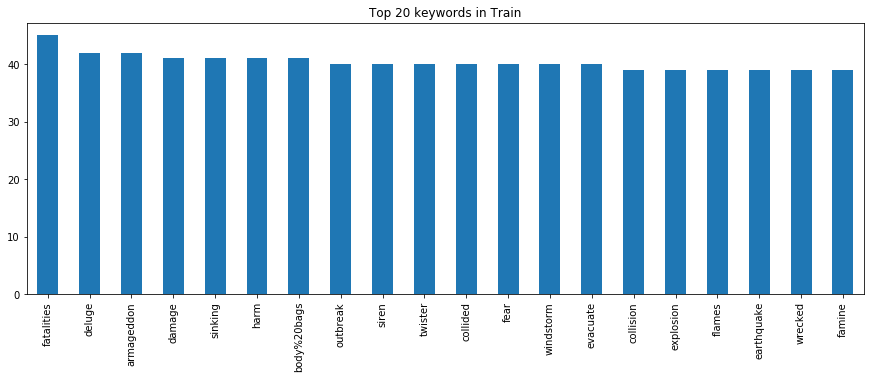

In [6]:
# Top 20 keywords in train

print(f"Total keywords in train set: {data.keyword.nunique()}")

fig, ax = plt.subplots(figsize=(15,5))

data.keyword.value_counts()[:20].plot(kind="bar")
ax.set_title("Top 20 keywords in Train")

plt.show()

In [8]:
def disaster_probability(df):
    """
    Imputes the empty values in the dataframe with "none" and groups df by keyword column.
    Displays probability of a disaster when a keyword is used and the amount of times that word is listed in keywords.

    """
    x = df.copy()
    x.fillna("none")
    
    keyword_probability = x.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(
        columns={'text':'Count', 'target':'Disaster Probability'})

    return keyword_probability

In [9]:
keyword_prob = disaster_probability(data)

In [32]:
keyword_prob[keyword_prob["Disaster Probability"] > 0.8].sort_values("Disaster Probability", ascending=False)

,Count,Disaster Probability
keyword,,
wreckage,39,1.000000
derailment,39,1.000000
debris,37,1.000000
outbreak,40,0.975000
typhoon,38,0.973684
oil%20spill,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


Total locations in train set: 3341


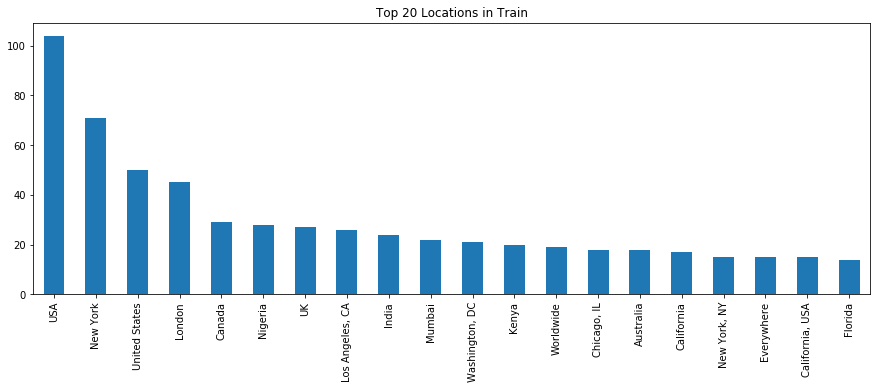

In [7]:
# Top 20 locations in train
print(f"Total locations in train set: {data.location.nunique()}")

fig, ax = plt.subplots(figsize=(15,5))

data.location.value_counts()[:20].plot(kind="bar")
ax.set_title("Top 20 Locations in Train")

plt.show()

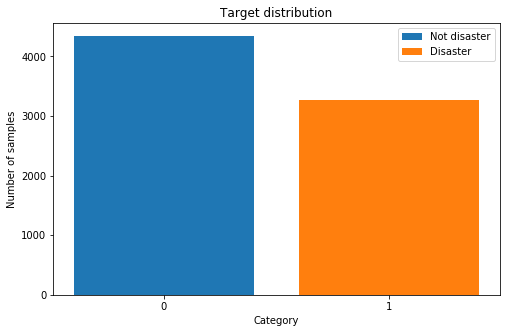

In [11]:
# distribution of target
disaster ={"1": sum(data[data.target == 1].target.value_counts())}
not_disaster = {"0": sum(data[data.target == 0].target.value_counts())}

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(not_disaster.keys(), not_disaster.values(), label="Not disaster")
ax.bar(disaster.keys(), disaster.values(), label="Disaster")
plt.title("Target distribution")
plt.xlabel("Category")
plt.ylabel("Number of samples")
ax.legend()

plt.show()

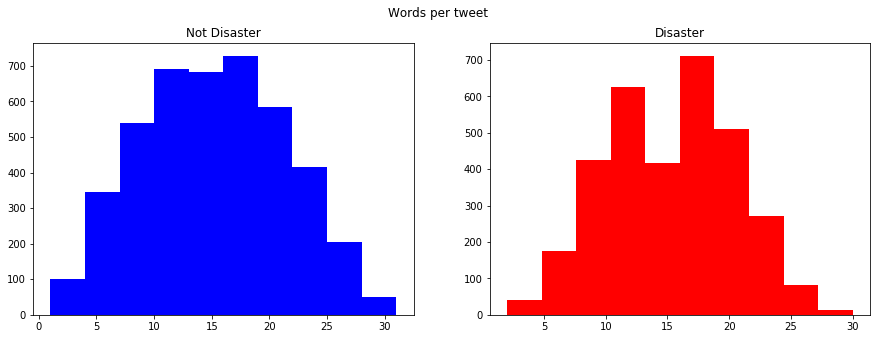

In [33]:
# words per tweet
disaster_uniques = data[data.target==1].text.str.split().map(lambda x: len(x))
non_disaster_uniques = data[data.target==0].text.str.split().map(lambda x: len(x))

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(non_disaster_uniques, color="blue")
axs[1].hist(disaster_uniques, color="red")

axs[0].set_title("Not Disaster")
axs[1].set_title("Disaster")
fig.suptitle("Words per tweet")

plt.show()

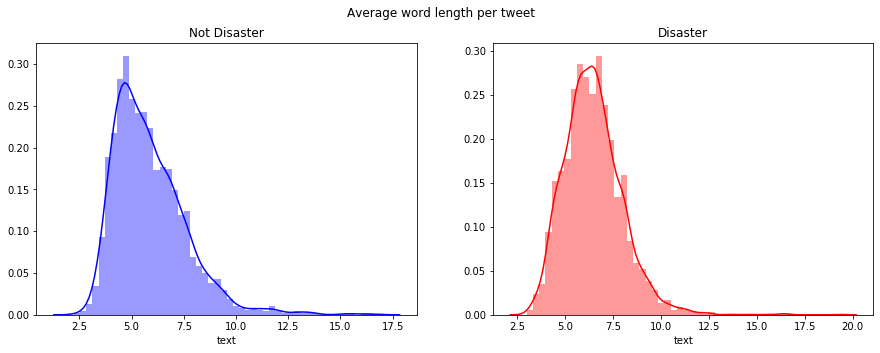

In [13]:
# average length per word
disaster_word_len = data[data.target==1].text.str.split().apply(lambda x : [len(i) for i in x])
non_disaster_word_len = data[data.target==0].text.str.split().apply(lambda x : [len(i) for i in x])

fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.distplot(non_disaster_word_len.map(lambda x: np.mean(x)), ax=axs[0], color="blue")
sns.distplot(disaster_word_len.map(lambda x: np.mean(x)), ax=axs[1], color="red")

axs[0].set_title("Not Disaster")
axs[1].set_title("Disaster")
fig.suptitle("Average word length per tweet")

plt.show()

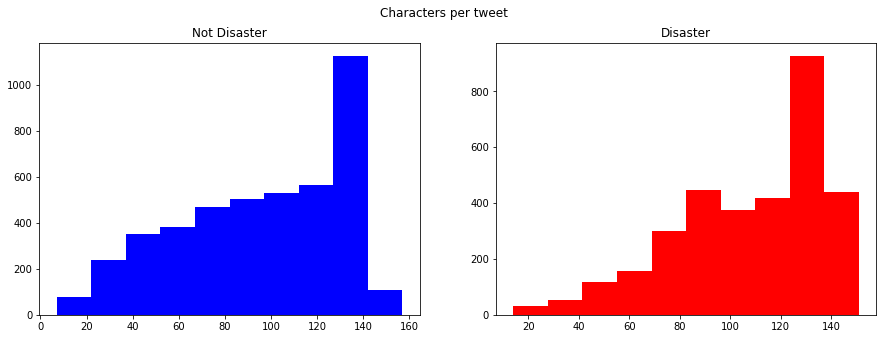

In [34]:
# characters per tweet
disaster_len = data[data.target==1].text.str.len()
not_disaster_len = data[data.target==0].text.str.len()

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(not_disaster_len, color="blue")
axs[1].hist(disaster_len, color="red")

axs[0].set_title("Not Disaster")
axs[1].set_title("Disaster")
fig.suptitle("Characters per tweet")

plt.show()

In [15]:
def create_corpus(df, target=None, var=str, full_corpus=False): 
    """
    Performs TweetTokenizer() from nltk and creates a corpus based on the distinct target group.
    When full_corpus=True or when target==None then a corpus without the
    distinct target group would be created.
    
    Parameters
    ----------
    df: DataFrame that contains text 
    var: The variable that contains the text to be processed
    target: The distinct category group should be created based on
    test: bool, when true a corpus for test set will be created
    
    Returns
    -------
    A corpus as a list
    """
    x = df.copy()
    
    # removing html
    x["text"] = x["text"].apply(lambda y: re.split(r"http\S+", str(y))[0])
    
    if full_corpus==True or target==None:
        corpus = flatten([TweetTokenizer(strip_handles=True).tokenize(i.lower()) for i in x[var].tolist()])
    else: 
        corpus = flatten([TweetTokenizer(strip_handles=True).tokenize(i.lower()) for i in x[x["target"]==target].text])
    return corpus

def extract_punctuation(corpus):
    """
    Extracts punctuation from the corpus.
    
    Parameters
    ----------
    corpus: list of tokens
    
    Returns
    -------
    A sorted dictionary which has the keys as the unique special character
    and the values is the amount of times that distinct key occurs within the corpus. 
    """
    dictionary = defaultdict(int)
    for i in corpus:
        if i in string.punctuation:
            dictionary[i] += 1
    return dictionary


def plot_dict_freq(dictionary):
    """
    Visualization of keys and their frequency.
    
    Parameters
    ----------
    dictionary: A dictionary type
    
    Returns
    -------
    The visualization of the frequency with respect to the unique key.
    """
    x, y = zip(*dictionary.items())
    
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(x, y)
    plt.ylabel("Frequency")

    return plt.show()

In [16]:
# creating a corpus of words based on the target 
disaster_corpus = create_corpus(df=data, var="text", target=1)
non_disaster_corpus = create_corpus(df=data, var="text", target=0)

# corpus of full train
train_corpus = create_corpus(df=data, var="text", full_corpus=True)

# extracting punctuation counts
disaster_corpus_punc = extract_punctuation(disaster_corpus)
non_disaster_corpus_punc = extract_punctuation(non_disaster_corpus)

full_train_corpus_punc = extract_punctuation(train_corpus)

In [17]:
disaster_corpus

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 '.',
 'canada',
 'all',
 'residents',
 'asked',
 'to',
 "'",
 'shelter',
 'in',
 'place',
 "'",
 'are',
 'being',
 'notified',
 'by',
 'officers',
 '.',
 'no',
 'other',
 'evacuation',
 'or',
 'shelter',
 'in',
 'place',
 'orders',
 'are',
 'expected',
 '13,000',
 'people',
 'receive',
 '#wildfires',
 'evacuation',
 'orders',
 'in',
 'california',
 'just',
 'got',
 'sent',
 'this',
 'photo',
 'from',
 'ruby',
 '#alaska',
 'as',
 'smoke',
 'from',
 '#wildfires',
 'pours',
 'into',
 'a',
 'school',
 '#rockyfire',
 'update',
 '=',
 '>',
 'california',
 'hwy',
 '.',
 '20',
 'closed',
 'in',
 'both',
 'directions',
 'due',
 'to',
 'lake',
 'county',
 'fire',
 '-',
 '#cafire',
 '#wildfires',
 '#flood',
 '#disaster',
 'heavy',
 'rain',
 'causes',
 'flash',
 'flooding',
 'of',
 'streets',
 'in',
 'manitou',
 ',',
 'col

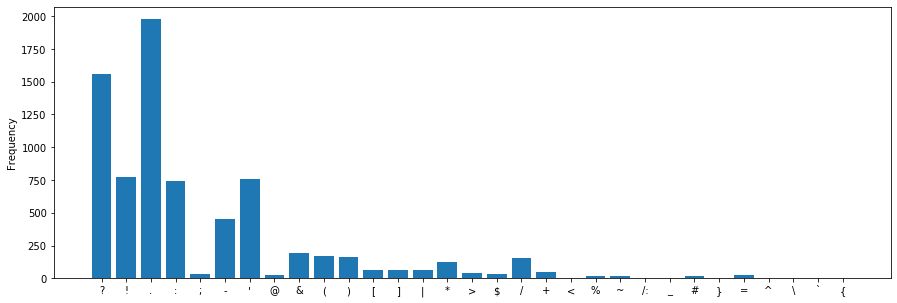

In [18]:
# visualising the frequency of a special character in non disasterous tweets
plot_dict_freq(non_disaster_corpus_punc)

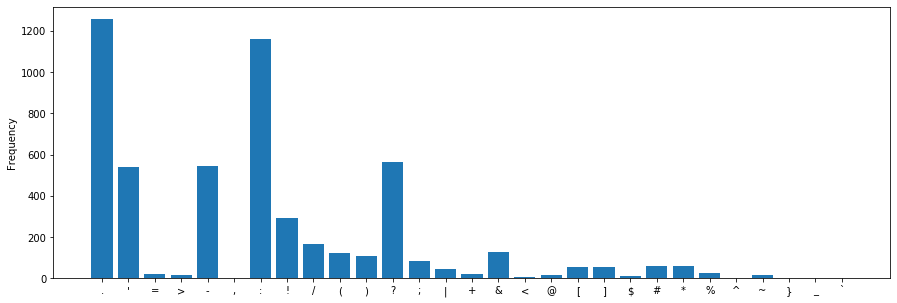

In [19]:
# visualizing the frequency of a special character in disasterous tweets
plot_dict_freq(disaster_corpus_punc)

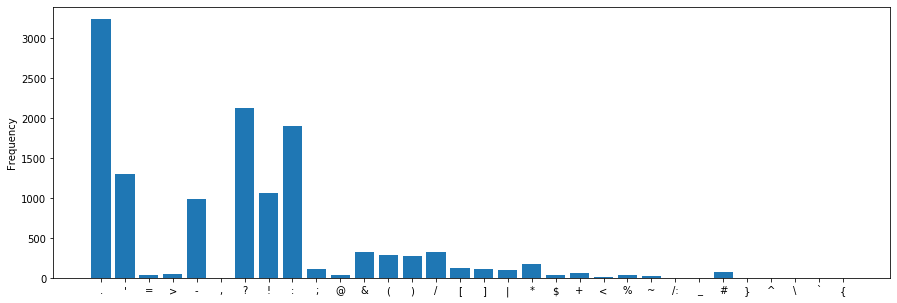

In [20]:
# visualizing the frequency of a special character in full train set corpus
plot_dict_freq(full_train_corpus_punc)

In [21]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

def get_top_n_words(corpus, ngrams=(1,1), n=None):
    """
    List the top n ngrams in corpus according to counts.
    
    Parameters
    ----------
    corpus: Text to be counted in Bag of Words
    ngrams: Amount of n words. ngrams=(min, max)
    n: Number of n words to display
    
    Returns
    -------
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),

('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer(ngram_range=ngrams).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [22]:
# Initialising nltk stopwords
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

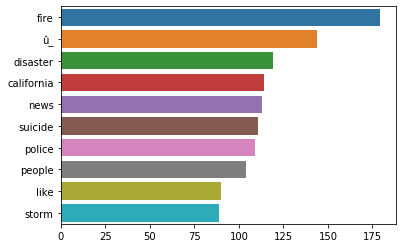

In [23]:
# Top 10 unigrams when there is a disaster tweet
# remove stopwods (using NLTK stopwords)
filtered_disaster_corpus = [word for word in disaster_corpus if word not in stop_words]
x,y = map(list, zip(*get_top_n_words(filtered_disaster_corpus, ngrams=(1,1), n=10)))
sns.barplot(x=y, y=x)
plt.show()

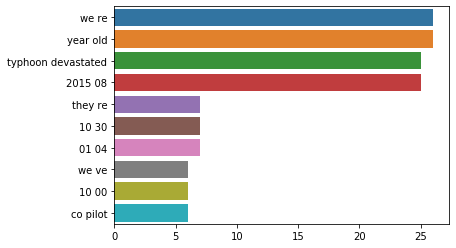

In [24]:
g# Top 10 bigrams when there is a disaster tweet
filtered_disaster_corpus = [word for word in disaster_corpus if word not in stop_words]
x,y = map(list, zip(*get_top_n_words(filtered_disaster_corpus, ngrams=(2,2), n=10)))
sns.barplot(x=y, y=x)
plt.show()

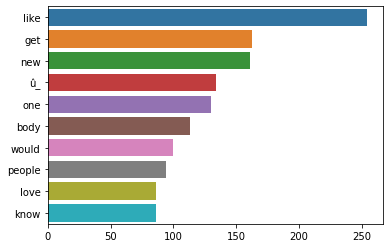

In [25]:
# Top 10 unigrams for non-disaster tweet
# removing stopwords
filtered_non_disaster_corpus = [word for word in non_disaster_corpus if word not in stop_words]
x,y = map(list, zip(*get_top_n_words(filtered_non_disaster_corpus, ngrams=(1,1), n=10)))
sns.barplot(x=y, y=x)
plt.show()

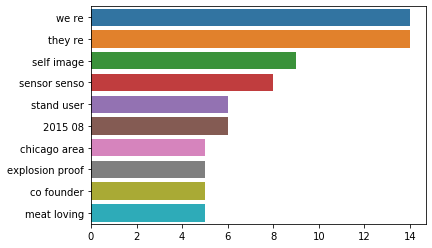

In [26]:
# Top 10 bigrams when there is a non-disaster tweet
filtered_non_disaster_corpus = [word for word in non_disaster_corpus if word not in stop_words]
x,y = map(list, zip(*get_top_n_words(filtered_non_disaster_corpus, ngrams=(2,2), n=10)))
sns.barplot(x=y, y=x)
plt.show()

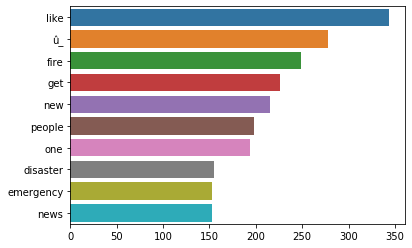

In [27]:
# Top 10 unigrams in full train corpus
filtered_train_corpus = [word for word in train_corpus if word not in stop_words]
x,y = map(list, zip(*get_top_n_words(filtered_train_corpus, n=10)))
sns.barplot(x=y, y=x)
plt.show()

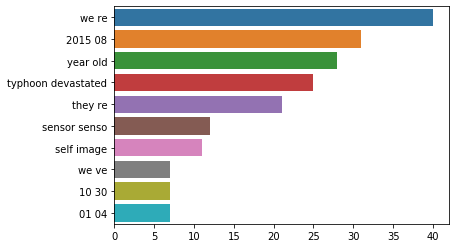

In [28]:
# Top 10 bigrams in full train corpus
filtered_train_corpus = [word for word in train_corpus if word not in stop_words]
x,y = map(list, zip(*get_top_n_words(filtered_train_corpus, ngrams=(2,2), n=10)))
sns.barplot(x=y, y=x)
plt.show()